<a href="https://colab.research.google.com/github/Kaiziferr/Deep_Learning_Workshop/blob/master/multilayer_perceptron/02_workshop_parameter_optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn import metrics

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/Kaiziferr/Deep_Learning_Workshop/master/workshop_keras_sklearn_introduction/diabetes.csv')
data_values = data.values

In [3]:
def create_base_model():
  model = Sequential()
  model.add(Dense(12, input_dim = 8, activation='relu', kernel_initializer='glorot_uniform'))
  model.add(Dense(8, activation='relu', kernel_initializer='glorot_uniform'))
  model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform'))
  model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

  return model

# **Data Split**

---



In [4]:
X = data_values[:,0:8]
y = data_values[:,8]

# **Houldot**

---



In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, shuffle = True, stratify = y)

# **Wrapper**

---



In [6]:
model = KerasClassifier(build_fn=create_base_model, epochs = 150, batch_size = 10, verbose = 0)

kfold = StratifiedKFold(n_splits=10, shuffle=True)
result = cross_val_score(model, X, y, cv = kfold)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  """Entry point for launching an IPython kernel.


In [7]:
result

array([0.67532468, 0.79220778, 0.75324672, 0.74025977, 0.6883117 ,
       0.66233766, 0.76623374, 0.70129871, 0.72368419, 0.65789473])

In [8]:
result.mean() , result.std()

(0.7160799682140351, 0.0438850915432986)

# **Optimización de hiperparametros**

---



In [9]:
def create_model_optimizer(optimizer = 'rmsprop', init = 'glorot_uniform'):
  model = Sequential()
  model.add(Dense(12, input_dim = 8, kernel_initializer=init, activation='relu'))
  model.add(Dense(8, kernel_initializer=init, activation='relu'))
  model.add(Dense(1, kernel_initializer=init, activation='relu'))
  model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
  return model

In [10]:
model = KerasClassifier(build_fn=create_model_optimizer, verbose = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  """Entry point for launching an IPython kernel.


In [11]:
optimizer = ['rmsprop', 'adam']
init = ['glorot_uniform', 'normal', 'uniform']
epochs = [50 ,100 ,150]
batch = [5, 10, 20]

param_grid = dict(optimizer = optimizer, epochs = epochs, batch_size = batch, init = init)
grid = GridSearchCV(estimator=model, param_grid=param_grid, refit=True, return_train_score=True, cv = 3)

In [12]:
grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f3b6756d710>,
             iid='deprecated', n_jobs=None,
             param_grid={'batch_size': [5, 10, 20], 'epochs': [50, 100, 150],
                         'init': ['glorot_uniform', 'normal', 'uniform'],
                         'optimizer': ['rmsprop', 'adam']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [13]:
print('Mejor: %f usando %s' % (grid.best_score_, grid.best_params_))

Mejor: 0.753472 usando {'batch_size': 10, 'epochs': 100, 'init': 'normal', 'optimizer': 'adam'}


In [14]:
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']

for mean, std, param in zip(means, stds, params):
  print('%f (%f) con %r' % (mean, std, param))

0.536458 (0.149507) con {'batch_size': 5, 'epochs': 50, 'init': 'glorot_uniform', 'optimizer': 'rmsprop'}
0.383681 (0.086353) con {'batch_size': 5, 'epochs': 50, 'init': 'glorot_uniform', 'optimizer': 'adam'}
0.684028 (0.064959) con {'batch_size': 5, 'epochs': 50, 'init': 'normal', 'optimizer': 'rmsprop'}
0.725694 (0.058669) con {'batch_size': 5, 'epochs': 50, 'init': 'normal', 'optimizer': 'adam'}
0.741319 (0.045472) con {'batch_size': 5, 'epochs': 50, 'init': 'uniform', 'optimizer': 'rmsprop'}
0.673611 (0.006496) con {'batch_size': 5, 'epochs': 50, 'init': 'uniform', 'optimizer': 'adam'}
0.565972 (0.107695) con {'batch_size': 5, 'epochs': 100, 'init': 'glorot_uniform', 'optimizer': 'rmsprop'}
0.572917 (0.132651) con {'batch_size': 5, 'epochs': 100, 'init': 'glorot_uniform', 'optimizer': 'adam'}
0.715278 (0.058049) con {'batch_size': 5, 'epochs': 100, 'init': 'normal', 'optimizer': 'rmsprop'}
0.701389 (0.060490) con {'batch_size': 5, 'epochs': 100, 'init': 'normal', 'optimizer': 'adam

In [15]:
model_final = grid.best_estimator_
model_final.get_params()

{'batch_size': 10,
 'build_fn': <function __main__.create_model_optimizer>,
 'epochs': 100,
 'init': 'normal',
 'optimizer': 'adam',
 'verbose': 0}

# **Prediccion**

---



### **Problema de optimización**

---



In [17]:
y_pred_ = model_final.predict(X_train)

##### **Metricas**

---



In [20]:
matrix = metrics.confusion_matrix(y_train, y_pred)
matrix

array([[336,  39],
       [ 91, 110]])

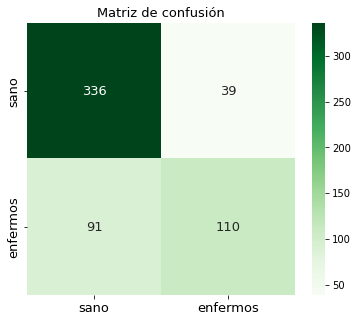

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (6,5))
sns.heatmap(matrix, annot=True, ax=ax, cmap=plt.cm.Greens, fmt = 'g', annot_kws={'size':13})
ax.set_title('Matriz de confusión', size = 13)
ax.xaxis.set_ticklabels(['sano', 'enfermos'])
ax.yaxis.set_ticklabels(['sano', 'enfermos'])
ax.tick_params(labelsize = 13)

In [27]:
print(f'Accuracy    : {metrics.accuracy_score(y_train, y_pred)}')
print(f'Kappa       : {metrics.cohen_kappa_score(y_train, y_pred)}')

print(f'Preddicción enfermos')
print(f'Predicción  : {metrics.precision_score(y_train, y_pred, [1], average="macro")}')
print(f'Recall      : {metrics.recall_score(y_train, y_pred, [1], average="macro")}')

VN = matrix[0,0]
FP = matrix[0,1]
specificity = VN/(VN+FP)

print(f'Specificity : {specificity}')
print(f'F1-score    : {metrics.f1_score(y_train, y_pred, [1], average="macro")}')

Accuracy    : 0.7743055555555556
Kappa       : 0.47156709150188425
Preddicción enfermos
Predicción  : 0.738255033557047
Recall      : 0.5472636815920398
Specificity : 0.896
F1-score    : 0.6285714285714286


### **Problema de inferencia**

---



In [41]:
y_pred = model_final.predict(X_test)

##### **Metricas**

---



In [43]:
matrix = metrics.confusion_matrix(y_test, y_pred)
matrix

array([[108,  17],
       [ 26,  41]])

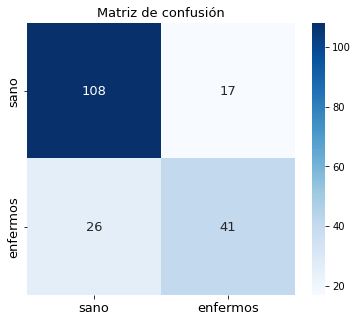

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (6,5))
sns.heatmap(matrix, annot=True, ax=ax, cmap=plt.cm.Blues, fmt = 'g', annot_kws={'size':13})
ax.set_title('Matriz de confusión', size = 13)
ax.xaxis.set_ticklabels(['sano', 'enfermos'])
ax.yaxis.set_ticklabels(['sano', 'enfermos'])
ax.tick_params(labelsize = 13)

In [46]:
print(f'Accuracy    : {metrics.accuracy_score(y_test, y_pred)}')
print(f'Kappa       : {metrics.cohen_kappa_score(y_test, y_pred)}')

print(f'Preddicción enfermos')
print(f'Predicción  : {metrics.precision_score(y_test, y_pred, [1], average="macro")}')
print(f'Recall      : {metrics.recall_score(y_test, y_pred, [1], average="macro")}')

VN = matrix[0,0]
FP = matrix[0,1]
specificity = VN/(VN+FP)

print(f'Specificity : {specificity}')
print(f'F1-score    : {metrics.f1_score(y_test, y_pred, [1], average="macro")}')

Accuracy    : 0.7760416666666666
Kappa       : 0.49124969189055945
Preddicción enfermos
Predicción  : 0.7068965517241379
Recall      : 0.6119402985074627
Specificity : 0.864
F1-score    : 0.6559999999999999
